In [13]:
import matplotlib.pyplot as plt
import os.path as osp
import numpy as np
num_gpus = 4
classes = ("Background", "Meat", "Nuts/seeds", "Eggs", "Beans/lentils/peas", "Fruit", "Grain", "Vegetables", "Dairy", "Sauce/Spread", "Soup/Drink")
palette = [[0,0,0], [255, 0, 0],[130, 65, 0], [255, 221, 0], [0, 255, 94], [255, 0, 157], [128, 0, 255], [0, 143, 24],[199, 199, 199], [0, 19, 166], [0, 184, 240]]
print(len(palette))

11


In [14]:
from mmcv import Config
import mmcv
cfg = Config.fromfile('./mmsegmentation/configs/deeplabv3plus/deeplabv3plus_r101-d8_512x512_40k_foodseg_with_label.py')

In [15]:
name = "deeplabv3plus_mobilenet_multi_combined_80k"
work_dir = './work_dirs/' + name

checkpoint_file = os.path.join(work_dir, "latest.pth")

In [16]:
from mmseg.apis import set_random_seed
norm_cfg = dict(type='SyncBN', eps=0.001, requires_grad=True)
cfg.data.train.img_dir='img_dir/train'
cfg.data.train.ann_dir='ann_dir/train'
cfg.data.test.img_dir='img_dir/test'
cfg.data.test.ann_dir='ann_dir/test'
cfg.data.val.img_dir='img_dir/test'
cfg.data.val.ann_dir='ann_dir/test'
cfg.data.train.data_root = './SegCombined/Images'
cfg.data.test.data_root = './SegCombined/Images'
cfg.data.val.data_root = './SegCombined/Images'

cfg.model.backbone=dict(
        type='MobileNetV3',
        arch='large',
        out_indices=(1, 3, 16),
        norm_cfg=norm_cfg)
cfg.model.pretrained = 'open-mmlab://contrib/mobilenet_v3_large'
cfg.model.decode_head.num_classes = len(classes)
cfg.model.auxiliary_head.num_classes = len(classes)
cfg.model.decode_head.in_channels = 960
cfg.model.decode_head.in_index = 2
cfg.model.decode_head.channels = 128
cfg.model.decode_head.c1_in_channels = 16
cfg.model.auxiliary_head.channels = 128
cfg.model.auxiliary_head.in_channels = 960
cfg.model.auxiliary_head.in_index = 2
cfg.data.samples_per_gpu = 4
cfg.data.workers_per_gpu=12


cfg.runner.max_iters = 80000
cfg.log_config = dict(
    interval=100,
    hooks=[
        dict(type='TextLoggerHook', by_epoch=False)
    ]
)
cfg.evaluation.interval = 5000
cfg.checkpoint_config.interval = 5000
cfg.checkpoint_config.save_optimizer = True
# cfg.model.backbone.frozen_stages=1
if(os.path.isfile(
    checkpoint_file)):
    cfg.resume_from = checkpoint_file
cfg.seed = 0
set_random_seed(0, deterministic=False)
print(f'Config:\n{cfg.pretty_text}')


Config:
norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='MultiEncoderDecoder',
    pretrained='open-mmlab://contrib/mobilenet_v3_large',
    backbone=dict(
        type='MobileNetV3',
        arch='large',
        out_indices=(1, 3, 16),
        norm_cfg=dict(type='SyncBN', eps=0.001, requires_grad=True)),
    decode_head=dict(
        type='MultiDepthwiseSeparableASPPHead',
        in_channels=960,
        in_index=2,
        channels=128,
        dilations=(1, 12, 24, 36),
        c1_in_channels=16,
        c1_channels=48,
        dropout_ratio=0.1,
        num_classes=11,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(type='CombinedCrossEntropyLoss', loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=960,
        in_index=2,
        channels=128,
        num_convs=1,
        concat_input=False,
        dropout_ratio=0.1,
        num_classes=11,
        norm

In [17]:
config_path = "mmsegmentation/configs/food103configs/" + name + ".py"


In [18]:
with open(config_path, "w") as f:
    f.write(cfg.pretty_text)

In [19]:
import torch
torch.cuda.empty_cache()


In [10]:
config_path

'mmsegmentation/configs/food103configs/deeplabv3plus_mobilenet_multi_combined_80k.py'

In [7]:
f"mmsegmentation/tools/dist_train.sh {config_path} {num_gpus}"

'mmsegmentation/tools/dist_train.sh mmsegmentation/configs/food103configs/deeplabv3plus_mobilenet_multi_combined_80k.py 4'

In [20]:
import os
work_dir = './work_dirs/' + name
checkpoint_file = os.path.join(work_dir, "latest.pth")
assert os.path.isfile(
    checkpoint_file), '`{}` not exist'.format(checkpoint_file)
checkpoint_file = os.path.abspath(checkpoint_file)
checkpoint_file

'/nfs/nfs9/home/nobackup/hli5/FoodCV/work_dirs/deeplabv3plus_mobilenet_multi_combined_80k/latest.pth'

In [21]:
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False
import mmcv
import numpy as np
from mmcv.runner import load_checkpoint
import mmcv.visualization.image as mmcv_image
# fix for colab

def imshow(img, win_name='', wait_time=0): plt.figure(
    figsize=(50, 50)); plt.imshow(img)


mmcv_image.imshow = imshow
from mmsegmentation.mmseg.apis import inference_segmentor, init_segmentor


config_fname = config_path
# build the model from a config file and a checkpoint file
model = init_segmentor(config_fname, checkpoint_file)
model.CLASSES = classes

/nobackup/hli5/miniconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/cnn/bricks/hsigmoid.py:31: UserWarning: In MMCV v1.4.4, we modified the default value of args to align with PyTorch official. Previous Implementation: Hsigmoid(x) = min(max((x + 1) / 2, 0), 1). Current Implementation: Hsigmoid(x) = min(max((x + 3) / 6, 0), 1).
  warnings.warn(
/nfs/nfs9/home/nobackup/hli5/FoodCV/mmsegmentation/mmseg/models/losses/combined_cross_entropy.py:211: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/nfs/nfs9/home/nobackup/hli5/FoodCV/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_igno

load checkpoint from local path: /nfs/nfs9/home/nobackup/hli5/FoodCV/work_dirs/deeplabv3plus_mobilenet_multi_combined_80k/latest.pth


In [22]:
import torch
from mmcv.parallel import collate, scatter
from mmseg.datasets.pipelines import Compose
# load and display an image with Matplotlib
from PIL import Image
def show_result_pyplot(model,
                       img,
                       result,
                       palette=None,
                       fig_size=(18, 6),
                       opacity=0.5,
                       title='',
                       block=True,
                       show_legend=False):
    """Visualize the segmentation results on the image.

    Args:
        model (nn.Module): The loaded segmentor.
        img (str or np.ndarray): Image filename or loaded image.
        result (list): The segmentation result.
        palette (list[list[int]]] | None): The palette of segmentation
            map. If None is given, random palette will be generated.
            Default: None
        fig_size (tuple): Figure size of the pyplot figure.
        opacity(float): Opacity of painted segmentation map.
            Default 0.5.
            Must be in (0, 1] range.
        title (str): The title of pyplot figure.
            Default is ''.
        block (bool): Whether to block the pyplot figure.
            Default is True.
    """
    
    original_image = Image.open(img)
    file_id = img.split('/')[-1].split('.')[0] + '.png'
    gt_path = 'FoodSeg103/Images/ann_dir_edited/test/'+file_id
    gt_labels = Image.open(gt_path).convert('RGB')
    gt_labels = np.array(gt_labels, dtype=np.uint8)
    # ratio = gt_labels.shape[0]/gt_labels.shape[1]
    width = 15
    height = 6
    gt_labels_ids = np.unique(gt_labels)
    for i in gt_labels_ids:
        gt_labels = np.where(gt_labels == [i,i,i], palette[int(i)], gt_labels)
    gt_labels = gt_labels/255

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(width,height))
    axes[0].title.set_text("Original Image")
    axes[0].imshow(original_image)
    axes[0].axis('off')
    axes[1].title.set_text("Ground Truth")
    axes[1].imshow(original_image)
    axes[1].imshow(gt_labels, alpha=opacity)
    axes[1].axis('off')
    if hasattr(model, 'module'):
        model = model.module
    img = model.show_result(
        img, result, palette=palette, show=False, opacity=opacity)
    uniques_set = set(np.unique(result))
    uniques_set.update(set(gt_labels_ids.flatten()))
    if(show_legend):
        custom_lines = []
        labels = []
        for i in uniques_set:
            labels.append(model.CLASSES[i])
            rgb_color = [v/255 for v in palette[i]]
            custom_lines.append(plt.Line2D([0], [0], color=tuple(rgb_color), lw=4))
        fig.legend(custom_lines, labels)
    axes[2].title.set_text("Prediction")
    axes[2].imshow(mmcv.bgr2rgb(img))
    axes[2].axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show(block=block)

class LoadImage:
    """A simple pipeline to load image."""

    def __call__(self, results):
        """Call function to load images into results.

        Args:
            results (dict): A result dict contains the file name
                of the image to be read.

        Returns:
            dict: ``results`` will be returned containing loaded image.
        """

        if isinstance(results['img'], str):
            results['filename'] = results['img']
            results['ori_filename'] = results['img']
        else:
            results['filename'] = None
            results['ori_filename'] = None
        img = mmcv.imread(results['img'])
        results['img'] = img
        results['img_shape'] = img.shape
        results['ori_shape'] = img.shape
        return results


def inference_segmentor(model, img):
    """Inference image(s) with the segmentor.

    Args:
        model (nn.Module): The loaded segmentor.
        imgs (str/ndarray or list[str/ndarray]): Either image files or loaded
            images.

    Returns:
        (list[Tensor]): The segmentation result.
    """
    cfg = model.cfg
    device = next(model.parameters()).device  # model device
    # build the data pipeline
    test_pipeline = [LoadImage()] + cfg.data.test.pipeline[1:]
    test_pipeline = Compose(test_pipeline)
    # prepare data
    data = dict(img=img)
    data = test_pipeline(data)
    data = collate([data], samples_per_gpu=1)
    if next(model.parameters()).is_cuda:
        # scatter to specified GPU
        data = scatter(data, [device])[0]
    else:
        data['img_metas'] = [i.data[0] for i in data['img_metas']]
    # forward the model
    with torch.no_grad():
        result, labels = model(return_loss=False, rescale=True, **data)

    return result, labels

In [23]:
import glob
import pandas as pd
labels_db = pd.read_csv("food103labels.csv",sep=',')
LABELS = list(model.CLASSES)[1:]
count = 0
def get_label(file_path):
    file_name = file_path.split('/')[-1]
    numpy_array = labels_db.loc[labels_db['filename'] == file_name][LABELS].to_numpy().astype('int64')
    return numpy_array
def to_one_hot(preds, classes):
    labels_classification = []
    for i in range(len(preds)):
        if(preds[i] == 1):
            labels_classification.append(classes[i+1])
    return ", ".join(labels_classification)

/nfs/nfs9/home/nobackup/hli5/FoodCV/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


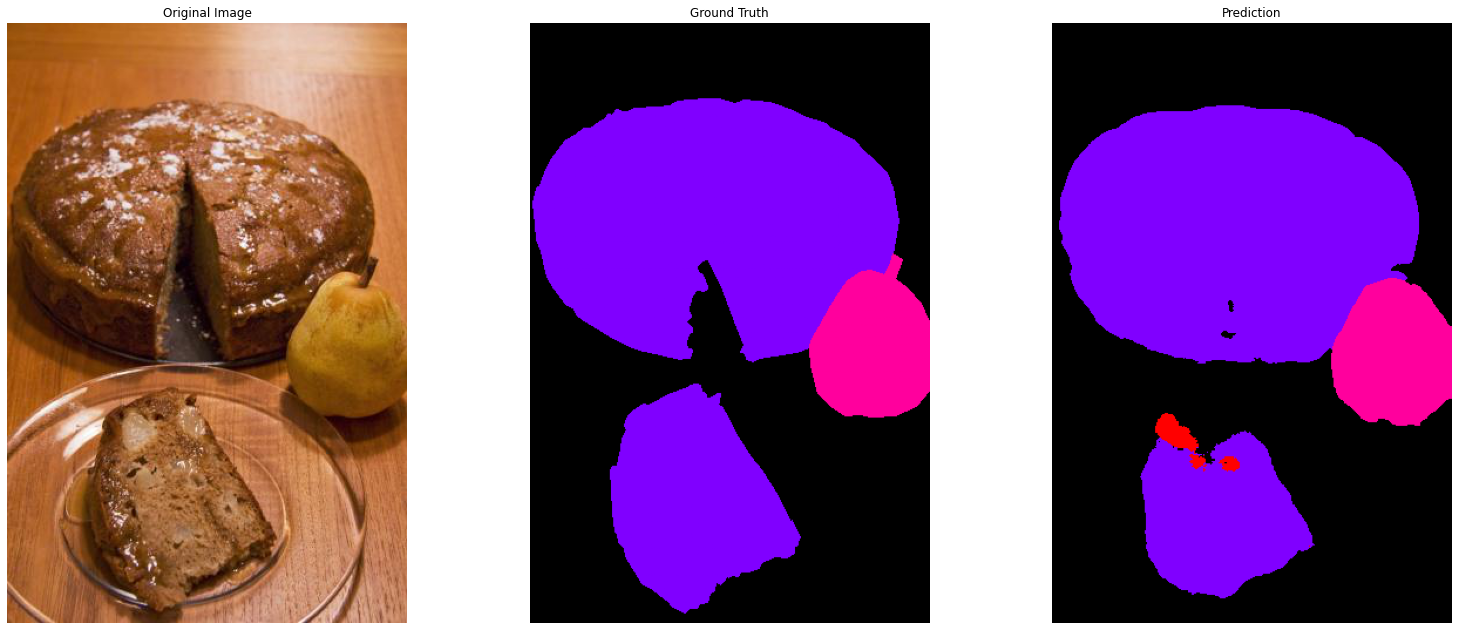

/nfs/nfs9/home/nobackup/hli5/FoodCV/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


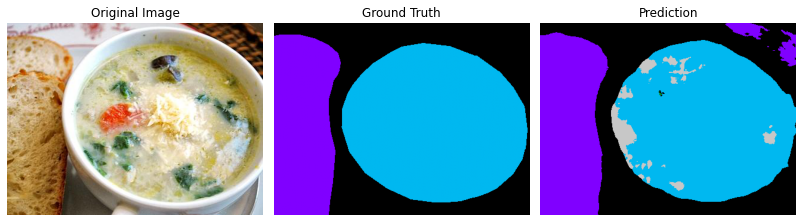

/nfs/nfs9/home/nobackup/hli5/FoodCV/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


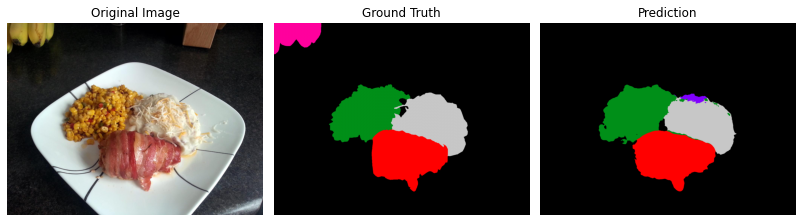

/nfs/nfs9/home/nobackup/hli5/FoodCV/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


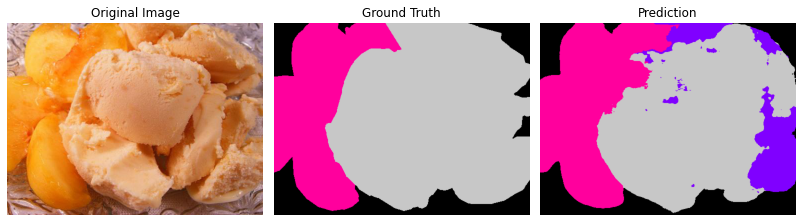

/nfs/nfs9/home/nobackup/hli5/FoodCV/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


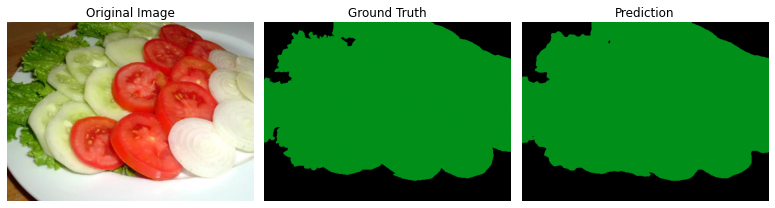

/nfs/nfs9/home/nobackup/hli5/FoodCV/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


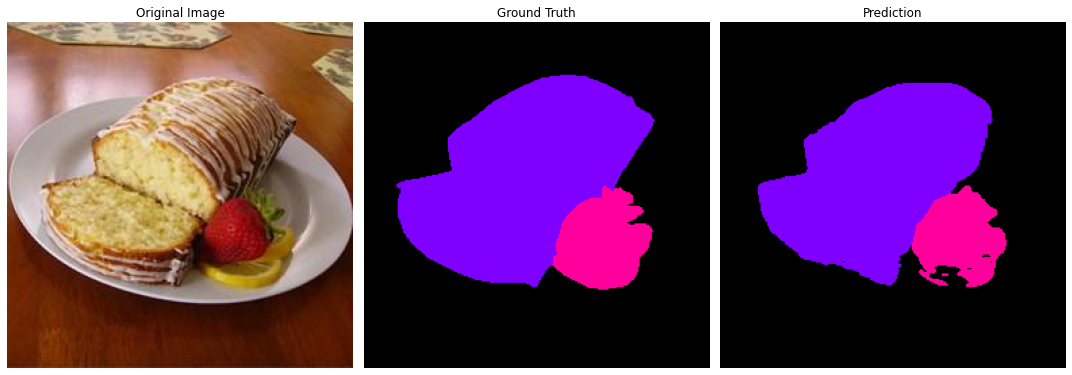

/nfs/nfs9/home/nobackup/hli5/FoodCV/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


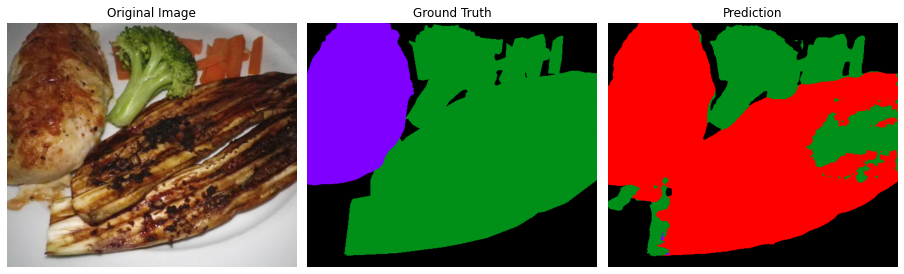

/nfs/nfs9/home/nobackup/hli5/FoodCV/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


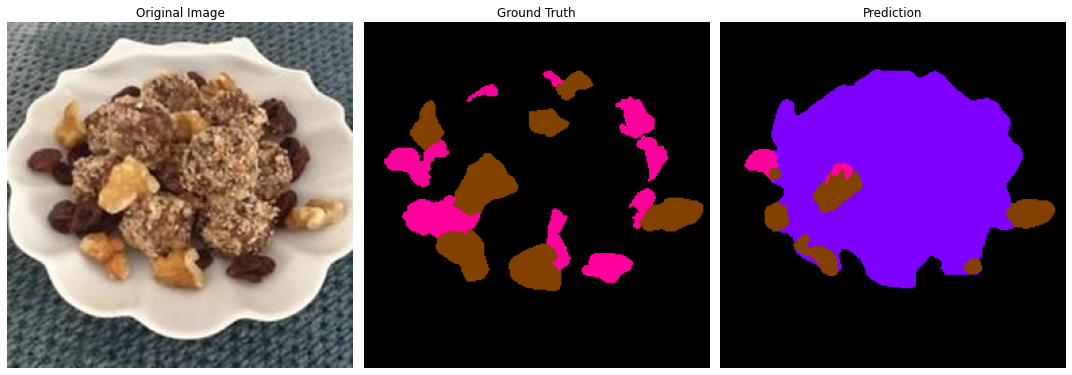

/nfs/nfs9/home/nobackup/hli5/FoodCV/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


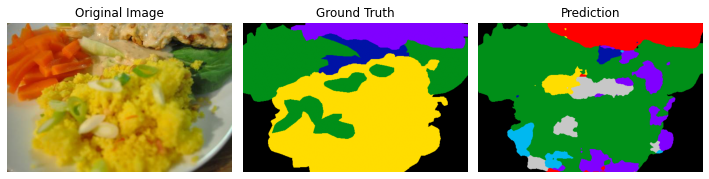

In [24]:
# test a single image and show the results
file_list = glob.glob("SegCombined/Images/img_dir/test/*.jpg")
import random
for i in range(9):
    img = random.choice(file_list)
    result, pred_labels = inference_segmentor(model, img)
    pred_labels = torch.nn.Sigmoid()(pred_labels)
    pred_labels[pred_labels>=0.5] = 1
    pred_labels[pred_labels<0.5] = 0
    gt_labels = to_one_hot(get_label(img).squeeze(),model.CLASSES)
    # title = "Multi-label classifier prediction:" + to_one_hot(pred_labels, model.CLASSES) + "\nGround truth: " + gt_labels
    show_result_pyplot(model, img, result, palette=palette, opacity=1,show_legend=False)

In [24]:
save_dir = work_dir + "/result"
save_dir

'./work_dirs/deeplabv3plus_mobilenet_multi_combined_80k/result'

In [30]:
import copy
all_predictions = np.zeros(shape=(len(file_list), len(LABELS)))
all_gt = np.zeros(shape=(len(file_list), len(LABELS)))
def get_label(file_path):    
    file_name = file_path.split('/')[-1]
    numpy_array = labels_db.loc[labels_db['filename'] == file_name][LABELS].to_numpy().astype('int64')
    return numpy_array
count = 0
for file in file_list:
    _, preds = inference_segmentor(model, file)
    preds = torch.nn.Sigmoid()(preds)
    preds = preds.cpu().numpy()
    all_predictions[count, :] = preds
    gt_label = get_label(file).squeeze()
    all_gt[count, :] = gt_label
    count+=1
    print(count, end='\r')
np.save("multi-task_multilabel_predictions.npy", all_predictions)
np.save("foodgroup_multilabel_gt.npy", all_gt)

In [31]:
all_predictions = np.load("multi-task_multilabel_predictions.npy")
all_gt = np.load("foodgroup_multilabel_gt.npy")

In [32]:
for i in range(len(LABELS)):
    print(LABELS[i])

Meat
Nuts/seeds
Eggs
Beans/lentils/peas
Fruit
Grain
Vegetables
Dairy
Sauce/Spread
Soup/Drink


In [33]:
from mmseg.core.evaluation import mean_ap
all_predictions = np.load("multi-task_multilabel_predictions.npy")
all_gt = np.load("foodgroup_multilabel_gt.npy")
mean_average_precision = mean_ap.mAP(all_predictions, all_gt)
for i in range(len(LABELS)):
    print(f"{mean_average_precision[i]}")
print(mean_average_precision.mean())

0.9421511273020647
0.7361099119498077
0.5862244071297136
0.3136423164280859
0.9310362573900633
0.9194288958016574
0.9871141865199137
0.6558010215781775
0.5632812785845406
0.10925160785494792
0.6744041010538973


In [34]:
all_predictions[all_predictions>=0.5] = 1
all_predictions[all_predictions<0.5] = 0

acc = (all_predictions==all_gt).sum(axis=0)
acc = acc/len(file_list)
for i in range(len(LABELS)):
    print(f"{acc[i]}")
print(acc.mean())

0.8710801393728222
0.9766052762568442
0.9696366351418616
0.9761075161772026
0.9208561473369836
0.8422100547536088
0.9223494275759084
0.8636137381781981
0.8750622200099551
0.89198606271777
0.9109507217521156
